# Notebook for project 2

In [1]:
import torch
import matplotlib.pyplot as plt
from model import Sequential, Sigmoid, SGD, MSE, ReLU, Conv2d, TransposeConv2d
from others.test_helpers import init_weights_wrapper
import torch.nn as nn
torch.set_grad_enabled(True)

In [2]:
noisy_imgs_1 , noisy_imgs_2 = torch.load("../data/train_data.pkl")
noisy_imgs_1 = (noisy_imgs_1  / 255.0).float()
noisy_imgs_2 = (noisy_imgs_2  / 255.0).float()

noisy_imgs_test, clean_images = torch.load("../data/val_data.pkl")
noisy_imgs_test = (noisy_imgs_test / 255.0).float()
clean_images = (clean_images / 255.0).float()

In [3]:
# Set to None for default init of weights
init_val = None
in_channels = 3
# Reduce (64, 128) to like (32, 64) or (16, 32) for lighter model
conv_1_in, conv_1_out = in_channels, 64
conv_2_in, conv_2_out = conv_1_out, 128
t_conv_1_in, t_conv_1_out = conv_2_out, conv_2_in
t_conv_2_in, t_conv_2_out = t_conv_1_out, in_channels

kernel_size, stride = (2,2), (2,2)

In [4]:
N2N = nn.Sequential(nn.Conv2d(conv_1_in, conv_1_out, kernel_size=kernel_size, stride=stride),
                    nn.ReLU(),
                    nn.Conv2d(conv_2_in, conv_2_out, kernel_size=kernel_size, stride=stride),
                    nn.ReLU(),
                    nn.ConvTranspose2d(t_conv_1_in, t_conv_1_out, kernel_size=kernel_size, stride=stride),
                    nn.ReLU(),
                    nn.ConvTranspose2d(t_conv_2_in, t_conv_2_out, kernel_size=kernel_size, stride=stride),
                    nn.Sigmoid())

In [5]:
if init_val is not None:
    N2N.apply(init_weights_wrapper(init_val=init_val))

In [6]:
N2N_no_torch = Sequential(Conv2d(conv_1_in, conv_1_out, kernel_size=kernel_size, stride=stride, init_val=init_val),
                          ReLU(),
                          Conv2d(conv_2_in, conv_2_out, kernel_size=kernel_size, stride=stride, init_val=init_val),
                          ReLU(),
                          TransposeConv2d(t_conv_1_in, t_conv_1_out, kernel_size=kernel_size, stride=stride, init_val=init_val),
                          ReLU(),
                          TransposeConv2d(t_conv_2_in, t_conv_2_out, kernel_size=kernel_size, stride=stride, init_val=init_val),
                          Sigmoid())

In [7]:
def get_things(kind="torch"):
    if kind == "torch":
        model = N2N
        criterion = nn.MSELoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        model = N2N_no_torch
        criterion = MSE()
        optimizer = SGD(model.param(), lr=lr)
    return (model, criterion, optimizer)

In [8]:
def train(model, criterion, optimizer, kind="torch"):
    for e in range(1,nb_epochs+1):
        print(f'epoch: {e}/{nb_epochs}', end='\r')
        for inputs, targets in zip(train_input.split(batch_size),
                                   train_targets.split(batch_size)):
            if kind=="torch":
                output = model(inputs)
                loss = criterion(output, targets)
                optimizer.zero_grad() 
                loss.backward() 
                optimizer.step() 
            else:
                output = model.forward(inputs)
                loss = criterion.forward(output, targets)
                optimizer.zero_grad() 
                model.backward(criterion.backward())
                optimizer.step()
    print(f'Final loss: {loss}')

In [9]:
def show_test_imgs(model, kind="torch"):
    imgs = noisy_imgs_test.narrow(0, 16, 10)
    imgs2 = clean_images.narrow(0, 16, 10)
    
    if kind == "torch":
        results = model(imgs).detach().numpy()
    else: 
        results = model.forward(imgs).detach().numpy()

    for i in range(5):
      plt.imshow(imgs[i].cpu().T)
      plt.show()

      plt.imshow(results[i].T)
      plt.show()

In [10]:
batch_size = 10
nb_epochs = 20
lr = 10-4    
# Use only first 1000 images
train_input = noisy_imgs_1[:1000]
train_targets = noisy_imgs_2[:1000]

In [11]:
model_torch, criterion, optimizer = get_things("torch")

In [12]:
train(model_torch, criterion, optimizer, "torch")

Final loss: 0.017008788883686066


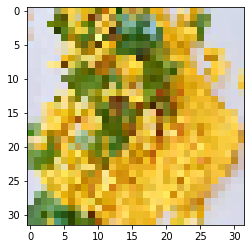

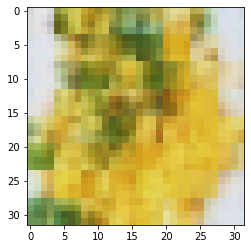

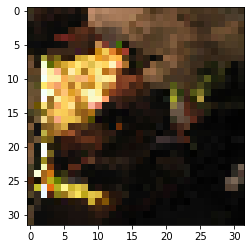

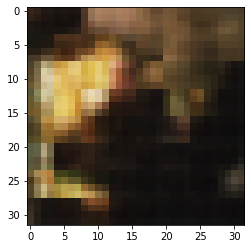

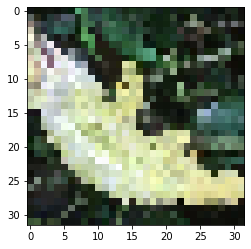

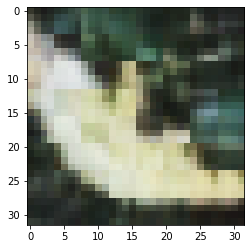

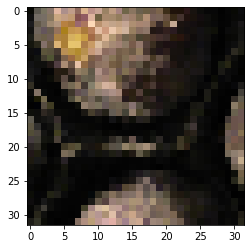

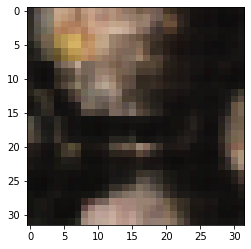

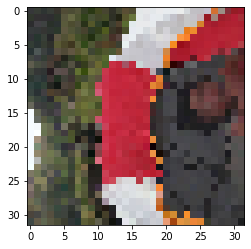

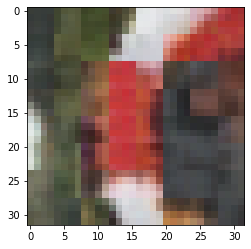

In [13]:
show_test_imgs(model_torch, "torch")

In [14]:
model_no_torch, criterion, optimizer = get_things("no_torch")

In [15]:
train(model_no_torch, criterion, optimizer, "no_torch")

Final loss: 0.019476713612675667


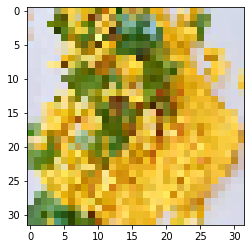

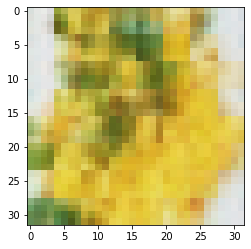

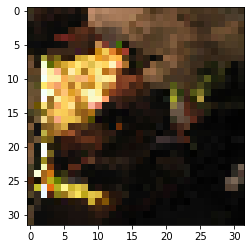

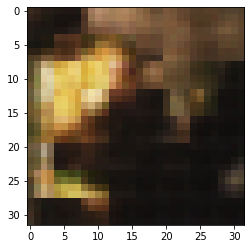

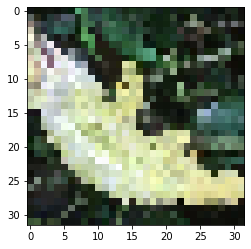

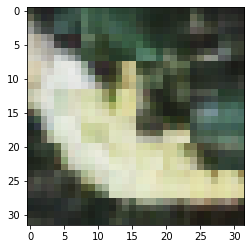

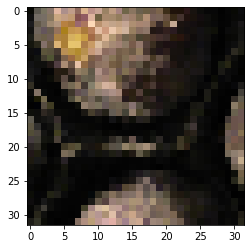

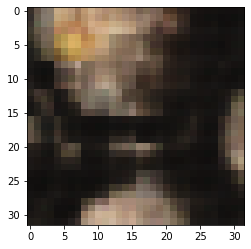

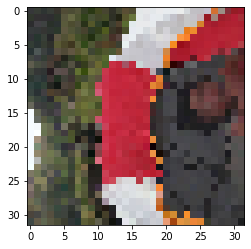

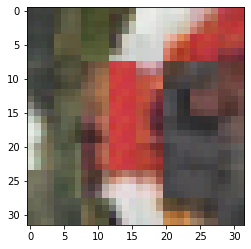

In [16]:
show_test_imgs(model_no_torch, "no_torch")